In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from eofs.multivariate.standard import MultivariateEof
from sklearn.preprocessing import StandardScaler, power_transform
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from eofs.standard import Eof
from pathlib import Path
import xarray as xr
import shap


## Data_Analysis Variables

Ensure version_1_data is true if using netcdf files ending in v1

In [3]:
directory_path = Path('CompleteData')
version_1_data = True

In [ ]:
files_only = ["CompleteData/" + entry.name for entry in directory_path.iterdir() if entry.is_file()]

# Corrects for a mistake in version 1 of the dataset
if version_1_data:
    lvl_700mb_ivalue = 0
else:
    lvl_700mb_ivalue = 1

In [5]:
ds = xr.open_mfdataset(files_only)

In [6]:
ds

<xarray.Dataset> Size: 8GB
Dimensions:          (levels: 2, valid_time: 533, angle: 720, radius: 501)
Coordinates:
  * levels           (levels) <U3 24B 'sfc' '700'
  * valid_time       (valid_time) datetime64[ns] 4kB 2023-07-21T18:00:00 ... ...
  * angle            (angle) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
  * radius           (radius) float64 4kB 0.0 0.5 1.0 1.5 ... 249.0 249.5 250.0
Data variables:
    gh               (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    rh               (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    t                (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    u                (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    v                (levels, valid_time, angle, radius) float32 2GB dask.array<chunksize=(2, 139, 720, 501), meta=np.ndarray>
    center_pressure  (valid_time) float32 2kB dask.array<chunksize=(139,), meta=np.ndarray>
    max_wind         (valid_time) float32 2kB dask.array<chunksize=(139,), meta=np.ndarray>
    center_lat       (valid_time) float64 4kB dask.array<chunksize=(139,), meta=np.ndarray>
    center_lon       (valid_time) float64 4kB dask.array<chunksize=(139,), meta=np.ndarray>
    storm_heading    (valid_time) float64 4kB dask.array<chunksize=(139,), meta=np.ndarray>
Attributes:
    history:   Created on 2025-12-14
    Overview:  Data originally obtained from the HAFS Repository (https://reg...

In [7]:
ds_nh = ds.where(ds['center_lat'] > 0)

Checking for NaN's in the dataset

In [8]:
# Total number of NaN's for each variables
ds_nh.isnull().sum().compute()

<xarray.Dataset> Size: 80B
Dimensions:          ()
Data variables:
    gh               int64 8B 4236236
    rh               int64 8B 4236236
    t                int64 8B 4236236
    u                int64 8B 4236236
    v                int64 8B 4236236
    center_pressure  int64 8B 0
    max_wind         int64 8B 0
    center_lat       int64 8B 0
    center_lon       int64 8B 0
    storm_heading    int64 8B 0
Attributes:
    history:   Created on 2025-12-14
    Overview:  Data originally obtained from the HAFS Repository (https://reg...

In [9]:
ds_clean = ds_nh.dropna(dim='valid_time')

In [10]:
ds_clean.isnull().sum().compute()

<xarray.Dataset> Size: 80B
Dimensions:          ()
Data variables:
    gh               int64 8B 0
    rh               int64 8B 0
    t                int64 8B 0
    u                int64 8B 0
    v                int64 8B 0
    center_pressure  int64 8B 0
    max_wind         int64 8B 0
    center_lat       int64 8B 0
    center_lon       int64 8B 0
    storm_heading    int64 8B 0
Attributes:
    history:   Created on 2025-12-14
    Overview:  Data originally obtained from the HAFS Repository (https://reg...

In [11]:
total_samples = len(ds_clean['valid_time'])
print(f'There are {total_samples} clean samples \nCleaning removed {len(ds_nh['valid_time']) - total_samples} samples' )

There are 512 clean samples 
Cleaning removed 21 samples


Text(0.5, 1.0, 'Distribution of Storm Strength within the dataset')

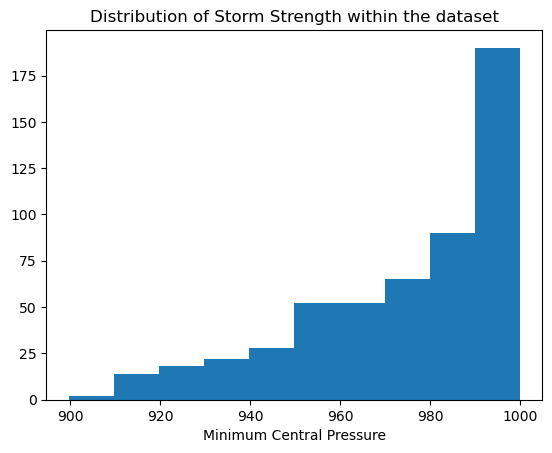

In [37]:
ds['center_pressure'].plot.hist()
plt.xlabel('Minimum Central Pressure')
plt.title('Distribution of Storm Strength within the dataset')

Text(20, 60000000, 'Skewness :[-1.26]')

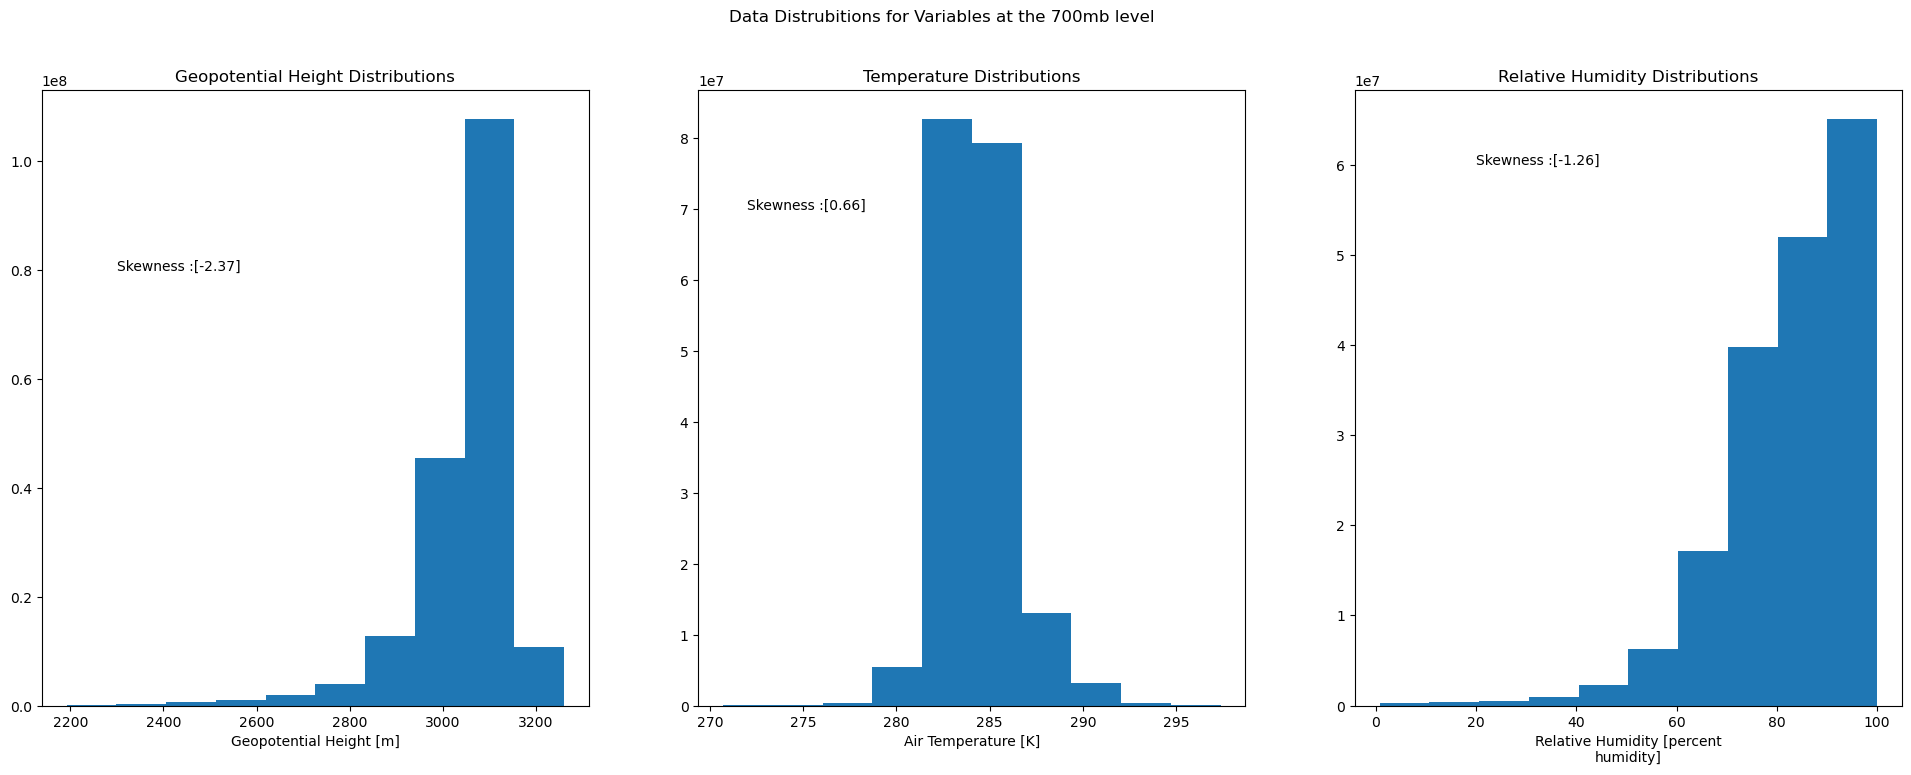

In [ ]:
# Plots to help decide on Normalization techniques 

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))

ds_clean['gh'].isel(levels = lvl_700mb_ivalue).plot.hist(ax = ax[0])
ds_clean['t'].isel(levels = lvl_700mb_ivalue).plot.hist(ax = ax[1])
ds_clean['rh'].isel(levels = lvl_700mb_ivalue).plot.hist(ax = ax[2])


ax[0].set_title('Geopotential Height Distributions')
ax[1].set_title('Temperature Distributions')
ax[2].set_title('Relative Humidity Distributions')
fig.suptitle('Data Distrubitions for Variables at the 700mb level')


t_data_700 = ds_clean['t'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
rh_data_700 = ds_clean['rh'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
gh_data_700 = ds_clean['gh'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)

gh_skew = scipy.stats.skew(gh_data_700)
t_skew = scipy.stats.skew(t_data_700)
rh_skew = scipy.stats.skew(rh_data_700)

ax[0].text(x = 2300, y = .8*10**8,  s = f'Skewness :{np.round(gh_skew,2)}')
ax[1].text(x = 272, y = 7 * 10**7, s = f'Skewness :{np.round(t_skew,2)}')
ax[2].text(x = 20, y = 6 * 10**7, s = f'Skewness :{np.round(rh_skew,2)}')

In [14]:
# Normalizing the Data
scaler = StandardScaler()

t_data_700 = ds_clean['t'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
scaled_t_data_700 = scaler.fit_transform(t_data_700).reshape(ds_clean['t'].isel(levels = lvl_700mb_ivalue).shape)

rh_data_700 = ds_clean['rh'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
scaled_rh_data_700 = power_transform(rh_data_700).reshape(ds_clean['rh'].isel(levels = lvl_700mb_ivalue).shape)

gh_data_700 = ds_clean['gh'].isel(levels = lvl_700mb_ivalue).values.reshape(-1,1)
scaled_gh_data_700 = power_transform(gh_data_700).reshape(ds_clean['gh'].isel(levels = lvl_700mb_ivalue).shape)


In [15]:
gh_data_700 = ds_clean['gh'].isel(levels = lvl_700mb_ivalue).values
rh_data_700 = ds_clean['rh'].isel(levels = lvl_700mb_ivalue).values
t_data_700 = ds_clean['t'].isel(levels = lvl_700mb_ivalue).values

Text(0.5, 0.98, 'Data Distrubitions after Normalization')

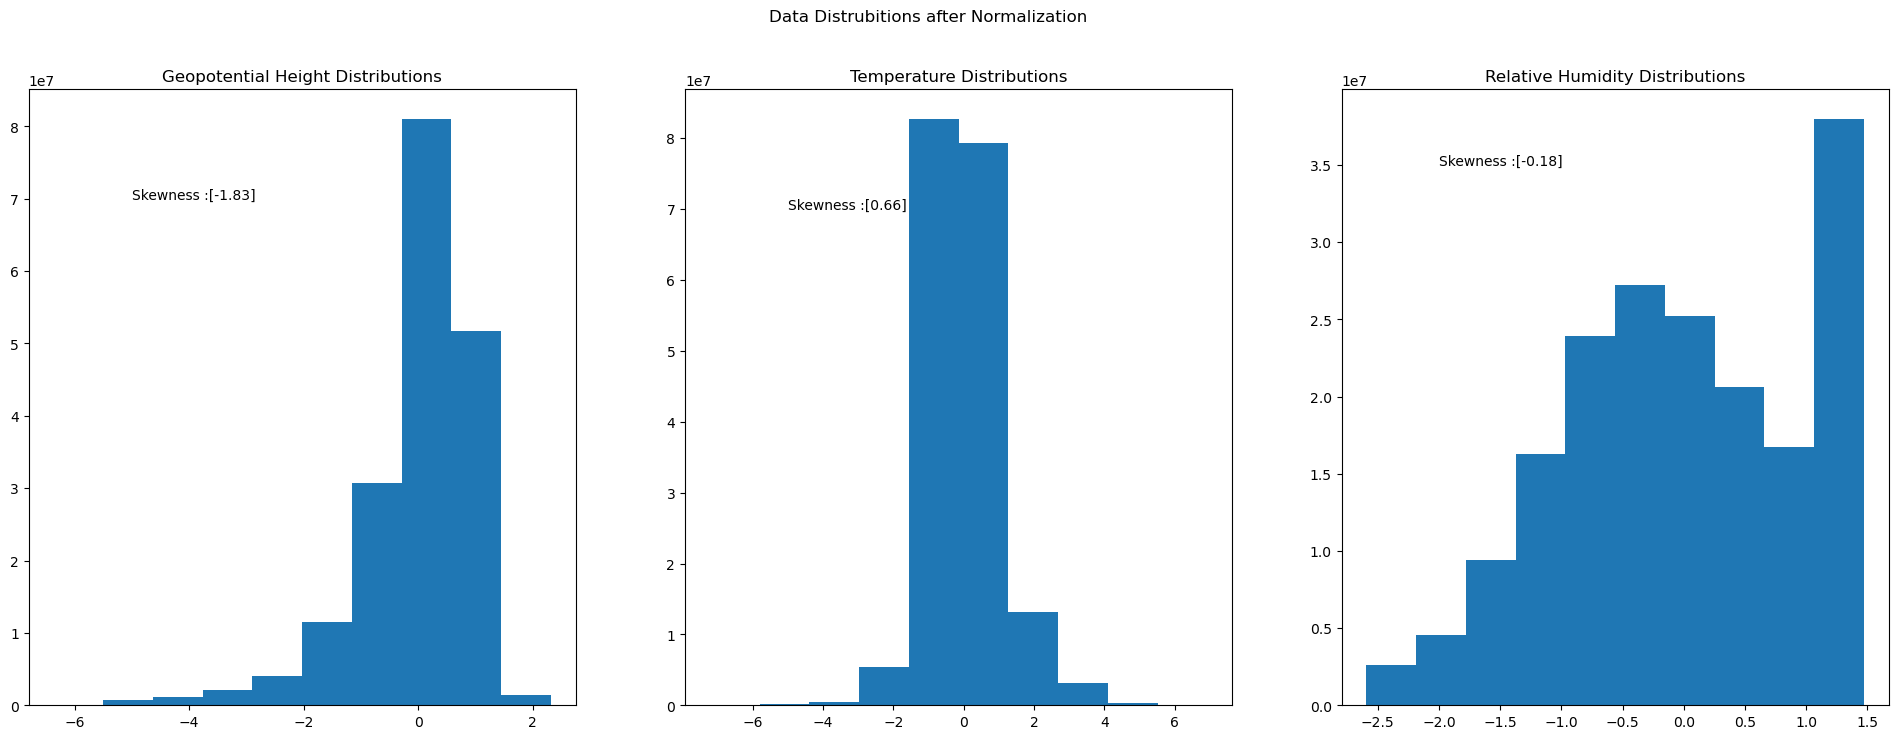

In [36]:

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))

ax[0].hist(scaled_gh_data_700.reshape(-1,1))
ax[1].hist(scaled_t_data_700.reshape(-1,1))
ax[2].hist(scaled_rh_data_700.reshape(-1,1))

ax[0].set_title('Geopotential Height Distributions')
ax[1].set_title('Temperature Distributions')
ax[2].set_title('Relative Humidity Distributions')

gh_skew = scipy.stats.skew(scaled_gh_data_700.reshape(-1,1))
t_skew = scipy.stats.skew(scaled_t_data_700.reshape(-1,1))
rh_skew = scipy.stats.skew(scaled_rh_data_700.reshape(-1,1))

ax[0].text(x = -5, y = 7*10**7,  s = f'Skewness :{np.round(gh_skew,2)}')
ax[1].text(x = -5, y = 7 * 10**7, s = f'Skewness :{np.round(t_skew,2)}')
ax[2].text(x = -2, y = 3.5 * 10**7, s = f'Skewness :{np.round(rh_skew,2)}')

fig.suptitle('Data Distrubitions after Normalization')



In [ ]:
# indexes based on wind speed category

ts = ds.where((ds['max_wind'] > 17.49) & (ds['max_wind'] < 32.94)).dropna(dim = 'valid_time')
cat1 = ds.where((ds['max_wind'] >= 17.49) & (ds['max_wind'] < 42.7)).dropna(dim = 'valid_time')
cat2 = ds.where((ds['max_wind'] >= 42.7) & (ds['max_wind'] < 49.39)).dropna(dim = 'valid_time')
cat3 = ds.where((ds['max_wind'] >= 49.39) & (ds['max_wind'] < 58.13)).dropna(dim = 'valid_time')
cat4 = ds.where((ds['max_wind'] >= 58.13) & (ds['max_wind'] < 70.48)).dropna(dim = 'valid_time')
cat5 = ds.where((ds['max_wind'] >= 70.48)).dropna(dim = 'valid_time')


In [ ]:
#creating composites based on hurricane category

gh_ts = ts['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_ts = ts['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_ts = ts['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat1 = cat1['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat1 = cat1['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat1 = cat1['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat2 = cat2['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat2 = cat2['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat2 = cat2['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat3 = cat3['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat3 = cat3['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat3 = cat3['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat4 = cat4['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat4 = cat4['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat4 = cat4['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
gh_cat5 = cat5['gh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
t_cat5 = cat5['t'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')
rh_cat5 = cat5['rh'].isel(levels = lvl_700mb_ivalue).mean(dim = 'valid_time')


Tropical Cyclone Composites

For the following figure, I just thought it may be interesting to create composites of geopotential height, temperature and relative humidity at the 700 mb level. Just to see if any features popped.

For all polar plots in this notebook, the zero degree line is the direction of storm motion.

Text(0.5, 0.98, 'Tropical Cyclone Variable Composites based on Tropical Cyclone Category')

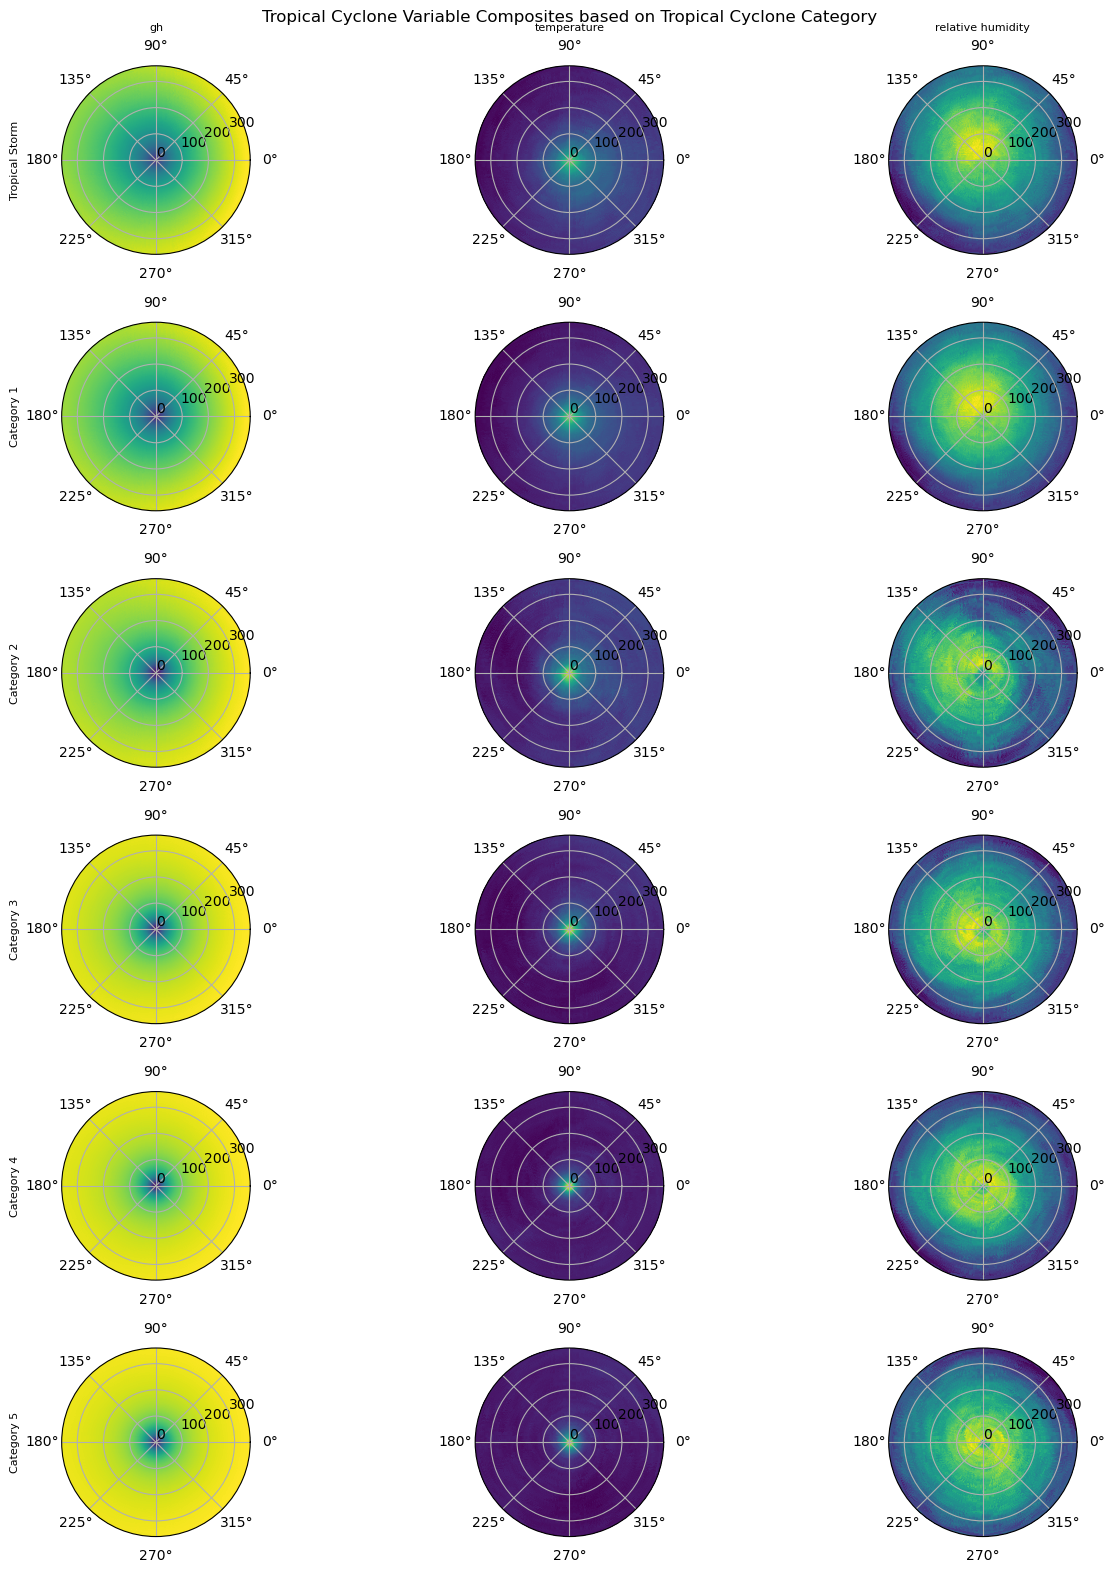

In [19]:
fig, ax = plt.subplots(nrows= 6, ncols=3, figsize=(16, 16),subplot_kw={'projection': 'polar'})

angle, radius = ds.angle.values, ds.radius.values

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_ts)
ax[0,1].pcolormesh(R, Theta, t_ts)
ax[0,2].pcolormesh(R, Theta, rh_ts)
ax[1,0].pcolormesh(R, Theta, gh_cat1)
ax[1,1].pcolormesh(R, Theta, t_cat1)
ax[1,2].pcolormesh(R, Theta, rh_cat1)
ax[2,0].pcolormesh(R, Theta, gh_cat2)
ax[2,1].pcolormesh(R, Theta, t_cat2)
ax[2,2].pcolormesh(R, Theta, rh_cat2)
ax[3,0].pcolormesh(R, Theta, gh_cat3)
ax[3,1].pcolormesh(R, Theta, t_cat3)
ax[3,2].pcolormesh(R, Theta, rh_cat3)
ax[4,0].pcolormesh(R, Theta, gh_cat4)
ax[4,1].pcolormesh(R, Theta, t_cat4)
ax[4,2].pcolormesh(R, Theta, rh_cat4)
ax[5,0].pcolormesh(R, Theta, gh_cat5)
ax[5,1].pcolormesh(R, Theta, t_cat5)
ax[5,2].pcolormesh(R, Theta, rh_cat5)

ax[0,0].set_ylabel('Tropical Storm', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('Category 1', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('Category 2', fontsize = 8, labelpad = 30)
ax[3,0].set_ylabel('Category 3', fontsize = 8, labelpad = 30)
ax[4,0].set_ylabel('Category 4', fontsize = 8, labelpad = 30)
ax[5,0].set_ylabel('Category 5', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('Tropical Cyclone Variable Composites based on Tropical Cyclone Category')

Calculating weights and constructing EOFs

In [20]:
max_range = 250.0
range_step = 0.5
angle_step = 0.5
range_gates = np.arange(0.0, max_range + range_step, range_step)

areas = []

for i, r in enumerate(range_gates):
    
    area = (angle_step/360) * np.pi * ((r + range_step)**2 - r**2)
    areas.append(area)

area_weight = areas/np.max(areas)

In [21]:
msolver = MultivariateEof([scaled_gh_data_700, scaled_t_data_700, scaled_rh_data_700], weights = [area_weight, area_weight, area_weight])
gh_eof, t_eof, rh_eof = msolver.eofsAsCorrelation(neofs=10)

In [22]:
multi_pcs = msolver.pcs(npcs = 3)

Text(0.5, 0.98, 'First 3 EOFs for a Multivariate EOF consisting of gh, Temp, and RH')

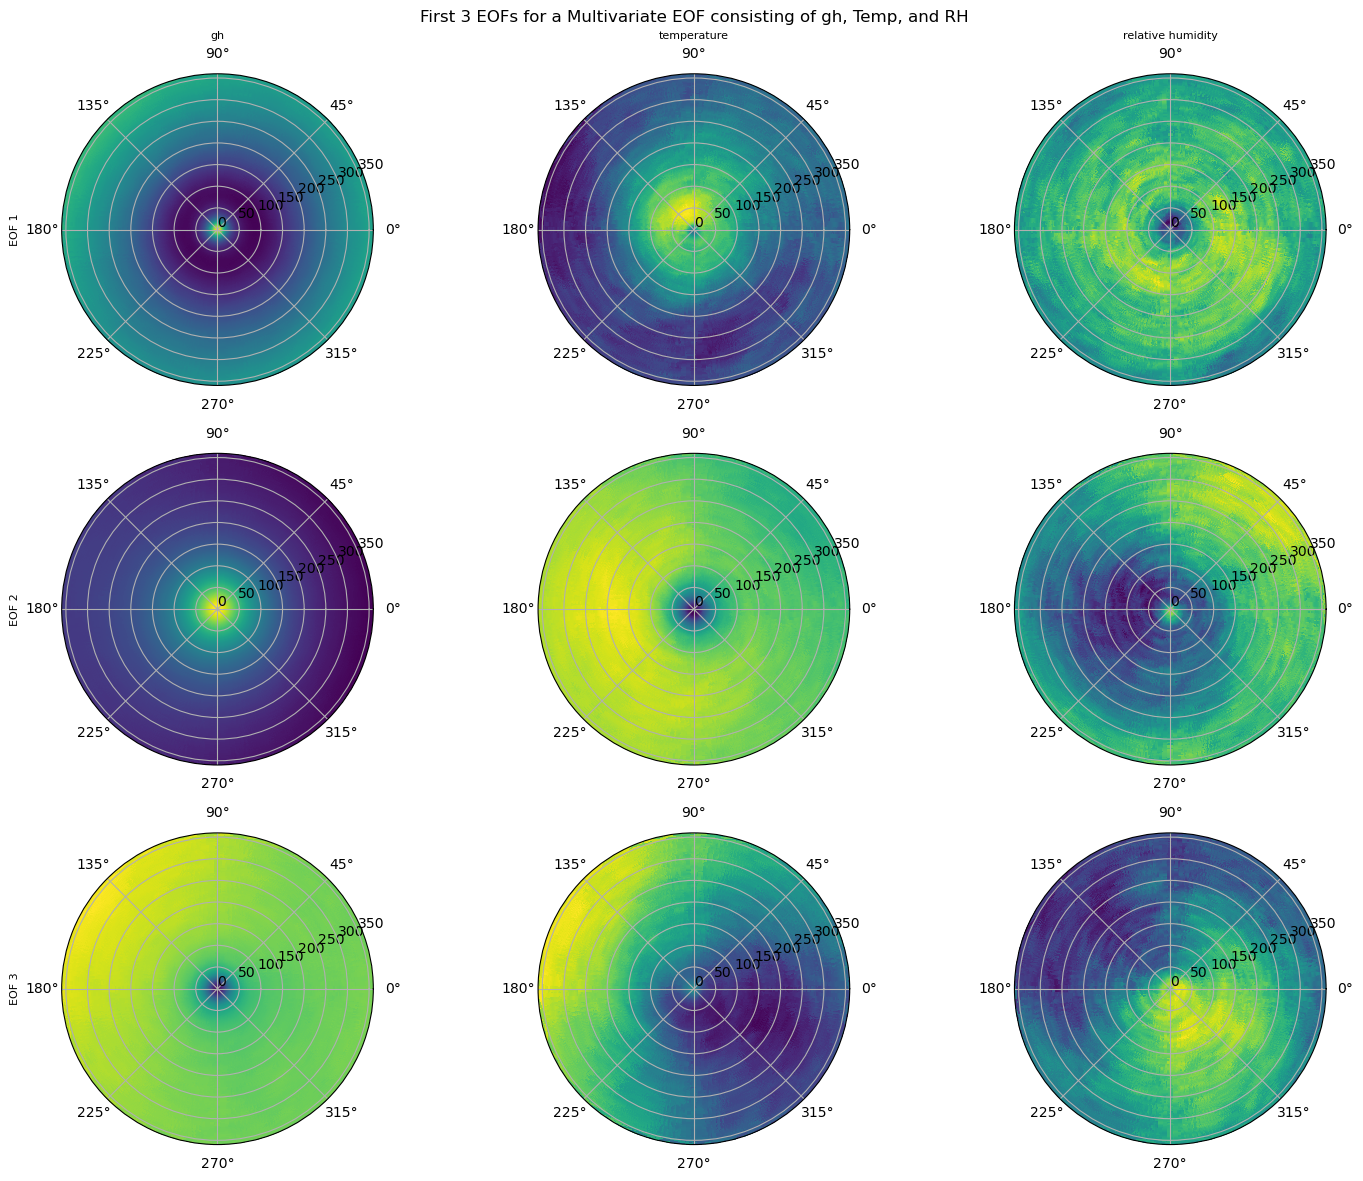

In [23]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_eof[0,:,:])
ax[0,1].pcolormesh(R, Theta, t_eof[0,:,:])
ax[0,2].pcolormesh(R, Theta, rh_eof[0,:,:])
ax[1,0].pcolormesh(R, Theta, gh_eof[1,:,:])
ax[1,1].pcolormesh(R, Theta, t_eof[1,:,:])
ax[1,2].pcolormesh(R, Theta, rh_eof[1,:,:])
ax[2,0].pcolormesh(R, Theta, gh_eof[2,:,:])
ax[2,1].pcolormesh(R, Theta, t_eof[2,:,:])
ax[2,2].pcolormesh(R, Theta, rh_eof[2,:,:])

ax[0,0].set_ylabel('EOF 1', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('EOF 2', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('EOF 3', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('First 3 EOFs for a Multivariate EOF consisting of gh, Temp, and RH')

Text(0.5, 0, 'EOF number')

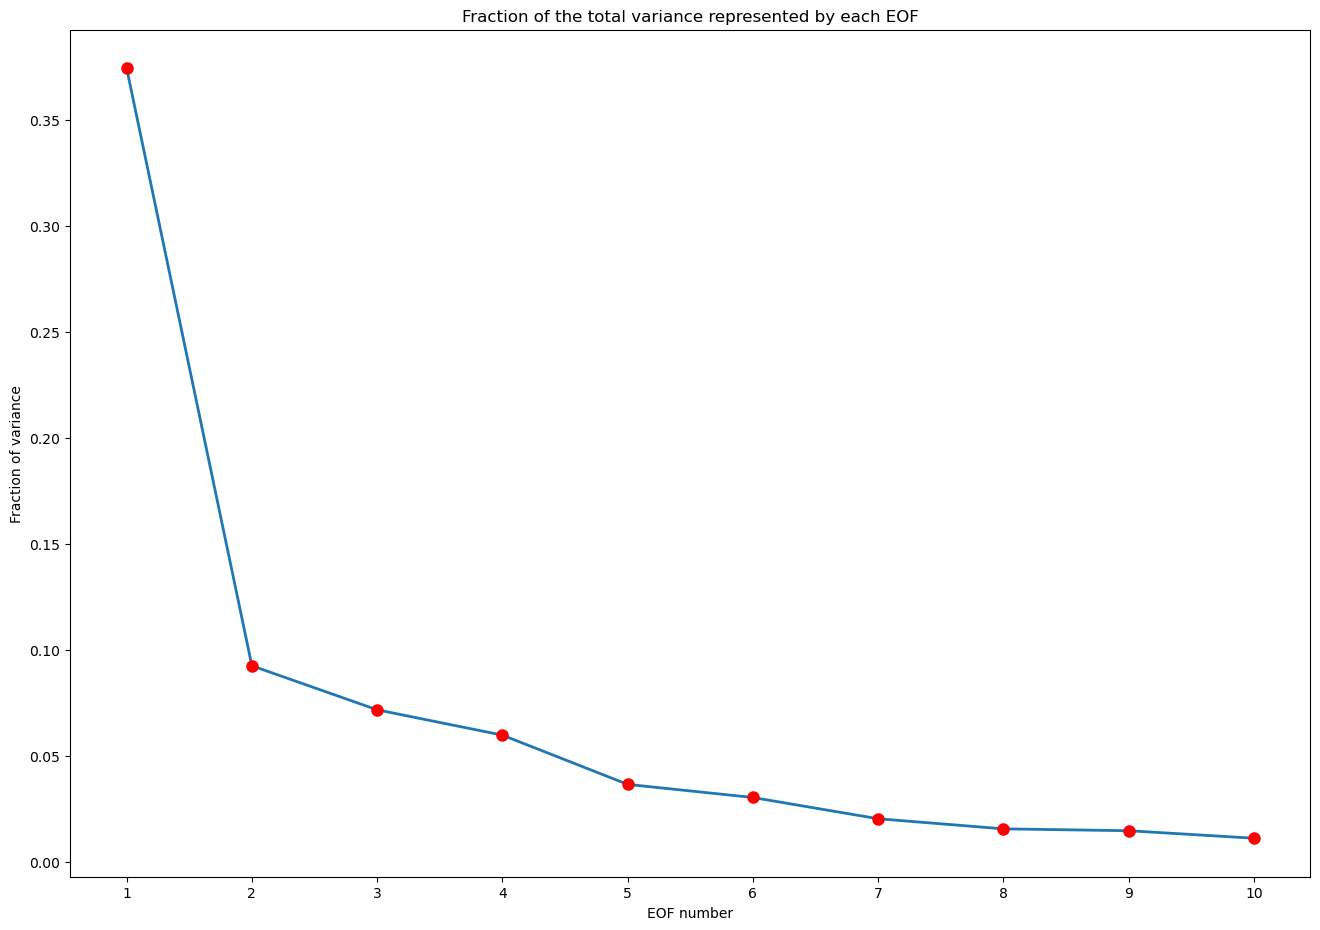

In [24]:
# Looking at the Variance

varfrac = msolver.varianceFraction()

# Plot the fraction of variance explained by each EOF

plt.figure(figsize = (16,11))
eof_num = range(1,11)
plt.plot(eof_num, varfrac[0:10], linewidth = "2")
plt.plot(eof_num, varfrac[0:10], linestyle = "None", marker = "o", color = "r", markersize = 8)
plt.xticks(range(1,11))
plt.title("Fraction of the total variance represented by each EOF")
plt.ylabel("Fraction of variance")
plt.xlabel("EOF number")

Multivariate Skill at estimating max surface wind speed

In [44]:
lin_model = LinearRegression()

multi_eof_lm = lin_model.fit(multi_pcs, ds_clean['max_wind'].values)
multi_scores = cross_val_score(lin_model, multi_pcs, ds_clean['max_wind'].values, scoring = 'neg_mean_squared_error', cv = 7)


multi_rmse_scores = np.sqrt(-multi_scores)
print("RMSE scores: ", multi_rmse_scores)
print(f"Mean RMSE: {np.round(multi_rmse_scores.mean(),2)} m/s")
print(f"RMSE Std: {np.round(multi_rmse_scores.std(),2)} m/s")

RMSE scores:  [ 8.85859124 14.70434664  9.8630816   9.63841152  6.31980549  7.01937927
 11.79281688]
Mean RMSE: 9.74 m/s
RMSE Std: 2.64 m/s


Multivariate Skill at estimating minimum central pressure

In [43]:
lin_model = LinearRegression()

multi_eof_lm = lin_model.fit(multi_pcs, ds_clean['center_pressure'].values)
multi_scores = cross_val_score(lin_model, multi_pcs, ds_clean['center_pressure'].values, scoring = 'neg_mean_squared_error', cv = 7)


multi_rmse_scores = np.sqrt(-multi_scores)
print("RMSE scores: ", multi_rmse_scores)
print(f"Mean RMSE: {np.round(multi_rmse_scores.mean(),2)} mb")
print(f"RMSE Std: {np.round(multi_rmse_scores.std(),2)} mb")

RMSE scores:  [ 7.43251048 13.21728394  9.11354396  9.93772057  6.45531478 10.02435801
 12.34005193]
Mean RMSE: 9.79 mb
RMSE Std: 2.25 mb


Single Variate EOFs for each of Geopotential Height, Temperature, and Relative Humidity

In [27]:
t_solver = Eof(scaled_t_data_700, weights = area_weight)
t_only_eof = t_solver.eofsAsCorrelation(neofs = 10)
t_only_pcs = t_solver.pcs(npcs = 3)


In [28]:
gh_solver = Eof(scaled_gh_data_700, weights = area_weight)
gh_only_eof = gh_solver.eofsAsCorrelation(neofs = 10)
gh_only_pcs = gh_solver.pcs(npcs = 3)

In [29]:
rh_solver = Eof(scaled_rh_data_700, weights = area_weight)
rh_only_eof = rh_solver.eofsAsCorrelation(neofs = 10)
rh_only_pcs = rh_solver.pcs(npcs = 3)

Examining Single Variate EOFs of each variable

Text(0.5, 0.98, 'First 3 EOFs for 3 single-variate EOFs consisting of gh, Temp, and RH')

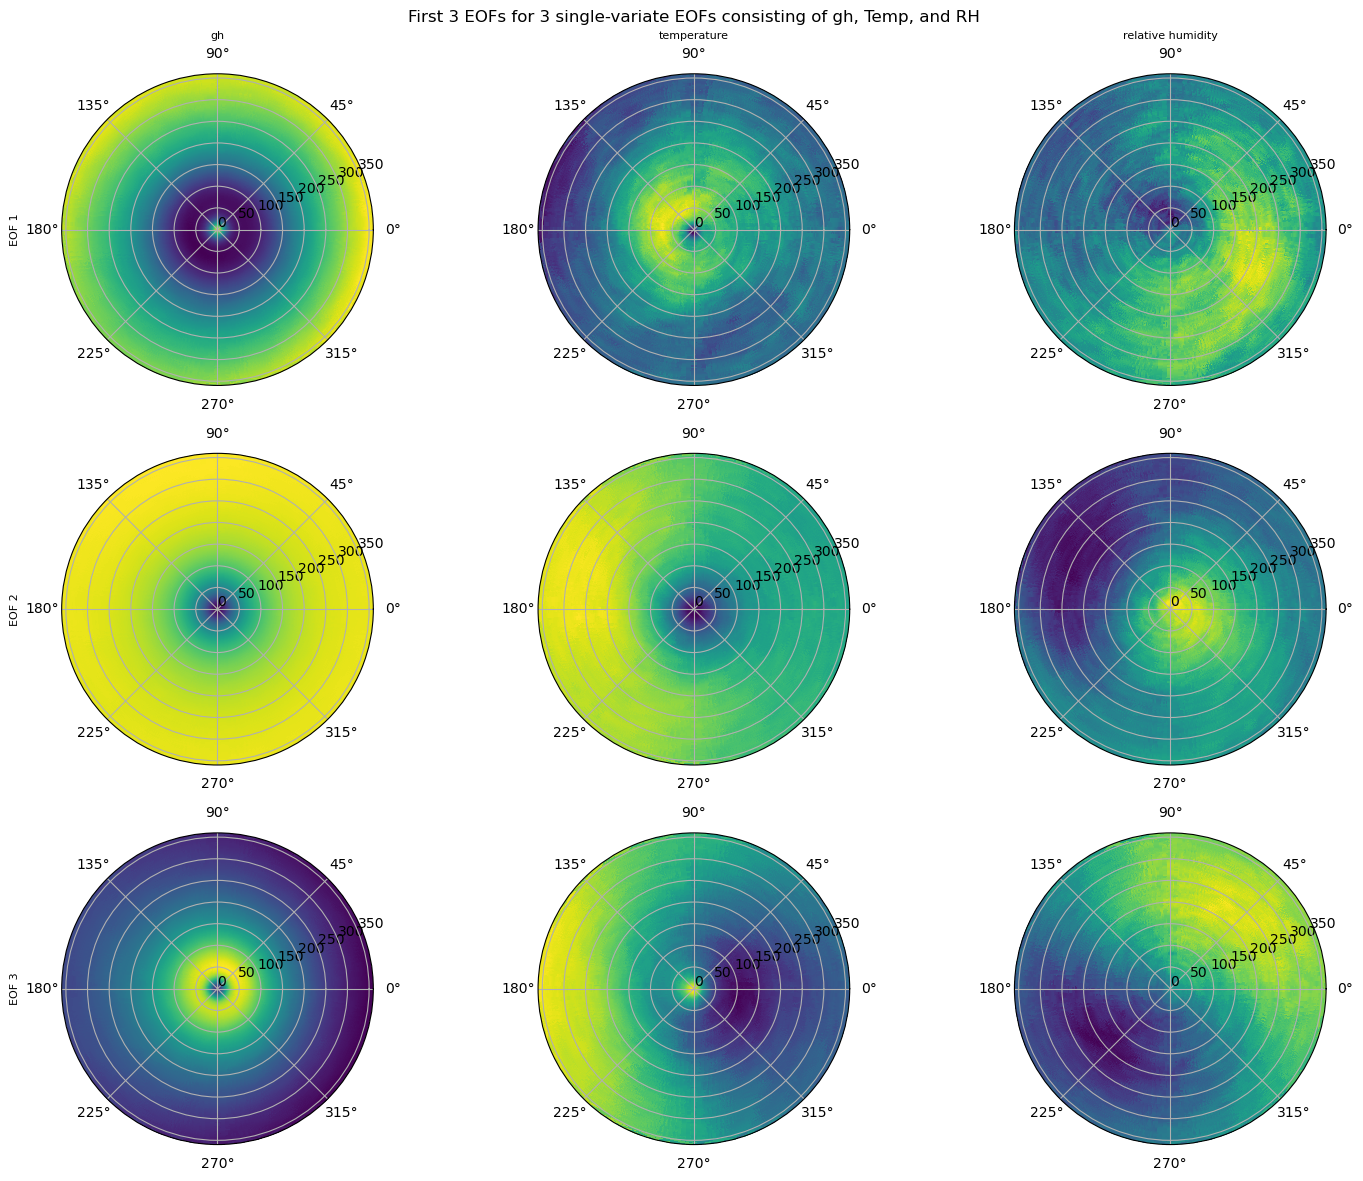

In [30]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_only_eof[0,:,:])
ax[0,1].pcolormesh(R, Theta, t_only_eof[0,:,:])
ax[0,2].pcolormesh(R, Theta, rh_only_eof[0,:,:])
ax[1,0].pcolormesh(R, Theta, gh_only_eof[1,:,:])
ax[1,1].pcolormesh(R, Theta, t_only_eof[1,:,:])
ax[1,2].pcolormesh(R, Theta, rh_only_eof[1,:,:])
ax[2,0].pcolormesh(R, Theta, gh_only_eof[2,:,:])
ax[2,1].pcolormesh(R, Theta, t_only_eof[2,:,:])
ax[2,2].pcolormesh(R, Theta, rh_only_eof[2,:,:])

ax[0,0].set_ylabel('EOF 1', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('EOF 2', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('EOF 3', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('First 3 EOFs for 3 single-variate EOFs consisting of gh, Temp, and RH')

## 3 Single Variate EOFS in a Multiple-Linear Regression



Skill predicting Max Wind

In [41]:
gh_t_rh_pcs = np.concatenate([gh_only_pcs, t_only_pcs, rh_only_pcs], axis = 1)
lin_model = LinearRegression()

single_eof_lm_mw = lin_model.fit(gh_t_rh_pcs, ds_clean['max_wind'].values)
single_scores_mw = cross_val_score(single_eof_lm_mw, gh_t_rh_pcs, ds_clean['max_wind'].values, scoring = 'neg_mean_squared_error', cv = 7)


single_rmse_scores_mw = np.sqrt(-single_scores_mw)
print("RMSE scores: ", single_rmse_scores_mw)
print(f"Mean RMSE: {np.round(single_rmse_scores_mw.mean(),2)} m/s" )
print(f"RMSE Std: {np.round(single_rmse_scores_mw.std(),2)} m/s")

RMSE scores:  [6.24857116 6.03338764 5.14550134 3.43613841 4.37894079 6.72052776
 4.98802655]
Mean RMSE: 5.28 m/s
RMSE Std: 1.06 m/s


In [32]:
feature_names = ['Geopotential Height EOF1', 'Geopotential Height EOF2', 'Geopotential Height EOF3', 
                 "Temperature EOF1", "Temperature EOF2", "Temperature EOF3", 
                 'Relative Humidity EOF1', 'Relative Humidity EOF2', 'Relative Humidity EOF3']



Skill predicting Minimum Central Pressure

In [42]:
gh_t_rh_pcs = np.concatenate([gh_only_pcs, t_only_pcs, rh_only_pcs], axis = 1)
lin_model = LinearRegression()

single_eof_lm_cmslp = lin_model.fit(gh_t_rh_pcs, ds_clean['center_pressure'].values)
single_scores_cmslp = cross_val_score(single_eof_lm_cmslp, gh_t_rh_pcs, ds_clean['center_pressure'].values, scoring = 'neg_mean_squared_error', cv = 7)


single_rmse_scores_cmslp = np.sqrt(-single_scores_cmslp)
print("RMSE scores: ", single_rmse_scores_cmslp)
print(f"Mean RMSE: {np.round(single_rmse_scores_cmslp.mean(),2)} mb")
print(f"RMSE Std: {np.round(single_rmse_scores_cmslp.std(),2)} mb")

RMSE scores:  [3.94488313 2.34040828 2.76529902 2.32549673 1.86316089 2.20157138
 2.32304638]
Mean RMSE: 2.54 mb
RMSE Std: 0.62 mb


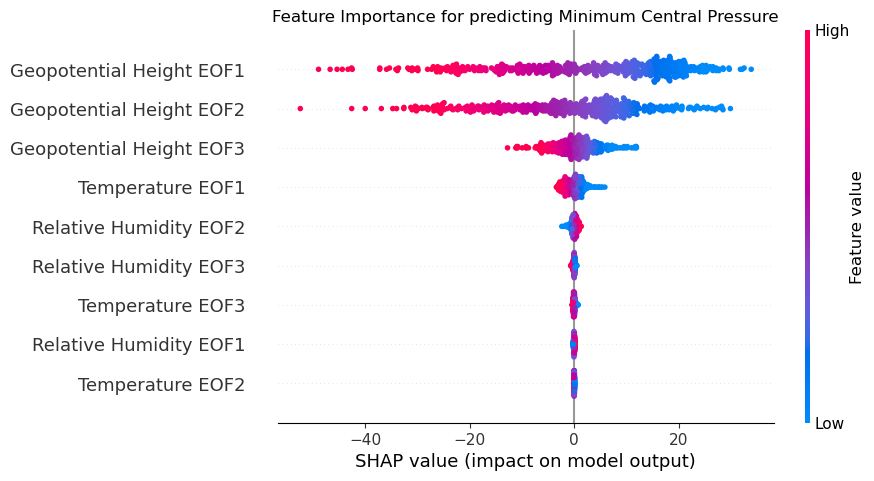

In [ ]:
feature_names = ['Geopotential Height EOF1', 'Geopotential Height EOF2', 'Geopotential Height EOF3', 
                 "Temperature EOF1", "Temperature EOF2", "Temperature EOF3", 
                 'Relative Humidity EOF1', 'Relative Humidity EOF2', 'Relative Humidity EOF3']



explainer_cmslp = shap.Explainer(single_eof_lm_cmslp, gh_t_rh_pcs, feature_names = feature_names)
shap_values_cmslp = explainer_cmslp(gh_t_rh_pcs)

shap.plots.beeswarm(shap_values_cmslp, show = False)

plt.title('Feature Importance for predicting Minimum Central Pressure')
plt.show()


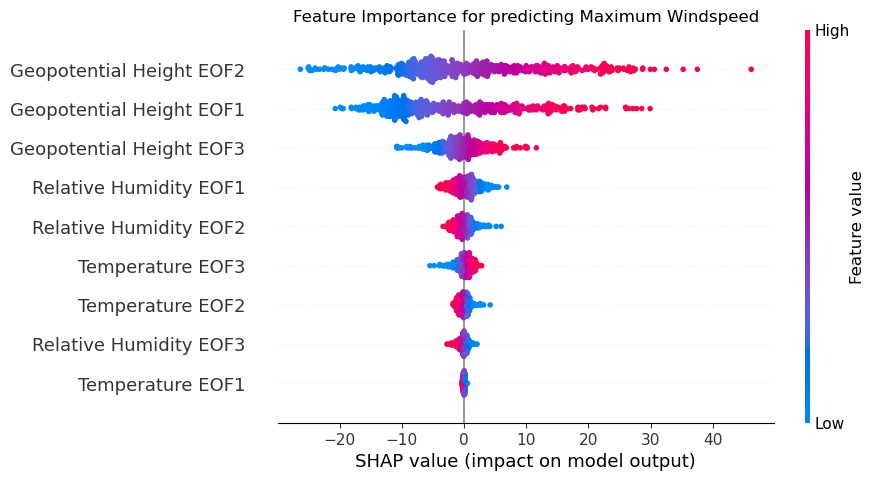

In [35]:
feature_names = ['Geopotential Height EOF1', 'Geopotential Height EOF2', 'Geopotential Height EOF3', 
                 "Temperature EOF1", "Temperature EOF2", "Temperature EOF3", 
                 'Relative Humidity EOF1', 'Relative Humidity EOF2', 'Relative Humidity EOF3']





explainer_mw = shap.Explainer(single_eof_lm_mw, gh_t_rh_pcs, feature_names = feature_names)
shap_values_mw = explainer_mw(gh_t_rh_pcs)

shap.plots.beeswarm(shap_values_mw, show = False)
plt.title('Feature Importance for predicting Maximum Windspeed')
plt.show()
